In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import src.solver_helper as helper
from src.traffic_world import TrafficWorld
from src.car_plotting_multiple import plot_multiple_cars, plot_cars, animate, plot_single_frame
from src.multiagent_mpc import MultiMPC, generate_warm_starts
from src.vehicle import Vehicle
from src.idm import IDM_acceleration, IDM_trajectory_prediction, get_lead_vehicle, MOBIL_lanechange
from contextlib import redirect_stdout


In [2]:
params = {}
params["T"] = 3
params["dt"] = 0.2
params["p_exec"] = 0.4
params["n_lanes"] = 2
params["n_other"] = 4
params["car_density"] = 5000
params["seed"] = 0
params["random_svo"] = 1
params["wall_CA"] = 0

i_mpc_start = 0
params["N"] = max(1, int(params["T"] / params["dt"]))

params["number_ctrl_pts_executed"] = max(1, int(np.floor(params["N"] * params["p_exec"])))

### Create the world and vehicle objects
world = TrafficWorld(params["n_lanes"], 0, 999999)

### Create the vehicle placement based on a Poisson distribution
MAX_VELOCITY = 25 * 0.447  # m/s
VEHICLE_LENGTH = 4.5  # m
time_duration_s = (params["n_other"] * 3600.0 /
                   params["car_density"]) * 10  # amount of time to generate traffic
initial_vehicle_positions = helper.poission_positions(params["car_density"],
                                                      int(time_duration_s),
                                                      params["n_lanes"],
                                                      MAX_VELOCITY,
                                                      VEHICLE_LENGTH,
                                                      position_random_seed=params["seed"])
position_list = initial_vehicle_positions[:params["n_other"]]

### Create the SVOs for each vehicle
if params["random_svo"] == 1:
    list_of_svo = [np.random.choice([0, np.pi / 4.0, np.pi / 2.01]) for i in range(params["n_other"])]
else:
    list_of_svo = [params["svo_theta"] for i in range(params["n_other"])]

(ambulance, amb_x0, all_other_vehicles,
 all_other_x0) = helper.initialize_cars_from_positions(params["N"], params["dt"], world, True, position_list,
                                                       list_of_svo)


In [3]:
from matplotlib.patches import Circle, Rectangle
from matplotlib.transforms import Affine2D
class CenterRectangle(Rectangle):
    def __init__(self, xy, width, height, angle=0.0, **kwargs):
        lower_xy = (xy[0] - width/2.0, xy[1]-height/2.0)
        Rectangle.__init__(self, lower_xy, width, height, angle=angle, **kwargs)

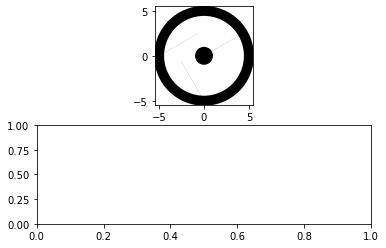

In [15]:

fig, axs = plt.subplots(2,1)

def add_steering_wheel(ax, angle_radians):
#     rotation = Affine2D().rotate_around(0.0, 0.0, angle)
#     rotation = None
    c1 = Circle((0,0), radius = 5, fill = None, linewidth=10)
    c2 = Circle((0,0), radius = 1, facecolor = 'black')
    
    angle_deg = np.rad2deg(angle_radians)
    
    right_rectangle = CenterRectangle((2.5,0), 5, 1, angle_deg, facecolor='black')
    left_rectangle = CenterRectangle((-2.5,0),5, 1, angle_deg, facecolor='black')
#     left_rectangle = Rectangle((-5*np.sin(angle),0), 5, 1, facecolor='black')
    bottom_rectangle = CenterRectangle((0, -2.5), 1, 5, angle_deg, facecolor='black')

    # c2 = Circle((0,0), radius = 3, fill = 'white')
    ax.add_patch(c1)
    ax.add_patch(c2)
    ax.add_patch(left_rectangle)
    ax.add_patch(right_rectangle)
    ax.add_patch(bottom_rectangle)

    
    
add_steering_wheel(axs[0], np.pi/2.0)
axs[0].set_xlim([-10,10])
axs[0].set_ylim([-10, 10])
axs[0].axis('square')
plt.show()

In [ ]:
plot_multiple_cars(0, world, ambulance, amb_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import time

class acceleration_button:
    def __init__(self):
        self.accel = 0
        self.steering = 0
        
    def on_button_clicked(self, delta_accel):
        self.accel += delta_accel
        print("new a", self.accel)
    
    def on_steer_clicked(self, delta_steering):
        self.steering -= delta_steering
        print("new steeer", self.steering)
    
    def on_speed_up_clicked(self, button):
        self.on_button_clicked(delta_accel = 1.0)
        
    def on_speed_down_clicked(self, button):
        self.on_button_clicked(delta_accel = -1.0)

    def on_steer_left_clicked(self, b):
        self.on_steer_clicked(-1)
        
    def on_steer_right_clicked(self, b):
        self.on_steer_clicked(1)        

button_speed_up = widgets.Button(description="Speed up!")
button_slow_down = widgets.Button(description="Slow down!")
button_steer_left = widgets.Button(description="Steer left")
button_steer_right = widgets.Button(description="Steer right")


output = widgets.Output()
display(button_speed_up, button_slow_down, button_steer_left, button_steer_right,
        output)

a_button = acceleration_button()
button_speed_up.on_click(a_button.on_speed_up_clicked)
button_slow_down.on_click(a_button.on_speed_down_clicked)
button_steer_left.on_click(a_button.on_steer_left_clicked)
button_steer_right.on_click(a_button.on_steer_right_clicked)

w = widgets.IntSlider()
display(w, output)

print(w.value)

In [ ]:
from src.human_keyboard import SteeringKeyboard


In [ ]:
N_total = 300
X_other = [np.zeros((6, N_total+1)) for i in range(len(all_other_vehicles))]
X_amb = np.zeros((6,N_total+1))

X_amb[:,0] = amb_x0
for i in range(len(X_other)):
    X_other[i][:,0] = all_other_x0[i]

    
idm_params = {
    "desired_time_gap": 0.1,
    "jam_distance": 4,
}

# out_file = open('/dev/null','rb')

for t in range(N_total):
    print(t)
    current_other_x0 = [X_other[i][:,t] for i in range(len(X_other))]
    current_amb_x0 = X_amb[:,t]
    current_other_veh = [all_other_vehicles[i] for i in range(len(X_other))]

    # Mobile lane change
    driver_x0 = current_amb_x0
    driver_veh = ambulance
    all_other_x0 = current_other_x0
    MOBIL_params = {
        "politeness_factor": 0.1,
    }
    # Compute whether lane change occurs
    desired_lane = True
    new_lane, accel = MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, current_other_veh, world, desired_lane,
                                       MOBIL_params, idm_params)
    if new_lane is not None:
        driver_veh.update_desired_lane(world, new_lane, True)
    # Compute IDM acceleration (ambulance)
    lead_veh = get_lead_vehicle(current_amb_x0, current_other_x0, world)
    if lead_veh is None:
        x_lead = current_amb_x0 + 999999
        v_lead = 999999
    else:
        x_lead = current_other_x0[lead_veh]
        v_lead = x_lead[4] * np.cos(x_lead[2])

    v_current = current_amb_x0[4] * np.cos(current_amb_x0[2])
    v_desired = ambulance.max_v
    bumper_distance = x_lead[0] - current_amb_x0[0] 

    idm_params["maximum_acceleration"] = ambulance.max_acceleration 
    a_IDM = IDM_acceleration(bumper_distance, v_lead, v_current, v_desired, idm_params)
    
    # Solve for steering angle
    ambulance.k_lat = 5.0
    ambulance.k_lan = 2.0
    ambulance.k_x_dot = 0.0
    ambulance.k_final = 0.0
    
    solver_params = {
        "k_slack" : 1000,
        "k_CA": 0.05,
        "k_CA_power": 1.0,
#         "constant_v": True,
    }
    
    warm_starts = generate_warm_starts(ambulance, world, current_amb_x0, [], params)
    u=None    
    for k_warm in warm_starts:
        try:
            steering_mpc = MultiMPC(ambulance, [], [], world, solver_params)
            n_mpc = 5
            steering_mpc.generate_optimization(params["N"], current_amb_x0, [], [], params=params, ipopt_params = {'print_level':0})
            
            u_warm, x_warm, x_des_warm = warm_starts[k_warm]

            steering_mpc.opti.set_initial(steering_mpc.u_ego, u_warm)
            steering_mpc.opti.set_initial(steering_mpc.x_ego, x_warm)
            steering_mpc.opti.set_initial(steering_mpc.xd_ego, x_des_warm)
#             with redirect_stdout(out_file):
            steering_mpc.solve(None, None)
            _, u, _ = steering_mpc.get_bestresponse_solution()            
        except RuntimeError:
            print("Solver didn't work")
            
        if u is not None:
            break
    if u is None:
        raise Exception("Solver didn't solve")
        
    # Update control and step the simulator    
    u_ego = np.array([[u[0,0]],[a_IDM*ambulance.dt]])
    
    # Update state with new control inputs
    x_ego_traj, _ = ambulance.forward_simulate_all(current_amb_x0, u_ego)    
    X_amb[:,t+1] = x_ego_traj[:, 1]
    

    # Other vehicles
    for ego_idx in range(len(all_other_vehicles)):
        N = 1
                           
    
        # Mobile lane change
        driver_x0 = current_other_x0[ego_idx] 
        driver_veh = all_other_vehicles[ego_idx]
        all_other_x0 = current_other_x0[:ego_idx] + current_other_x0[ego_idx+1:]  + [current_amb_x0]   
        all_other_veh = all_other_vehicles[:ego_idx] + all_other_vehicles[ego_idx+1:]  + [ambulance]    
        
        MOBIL_params = {
            "politeness_factor": 0.5,
        }
        new_lane, accel = MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, desired_lane,
                                       MOBIL_params, idm_params)
        if new_lane is not None:
            driver_veh.update_desired_lane(world, new_lane, True)
       
        
        driver_x0 = current_other_x0[ego_idx]
        dummy_x0 = current_other_x0[ego_idx] - 10000
        ado_x0s = current_other_x0[:ego_idx] + [dummy_x0] + current_other_x0[ego_idx+1:]  + [current_amb_x0]
        
        lead_veh = get_lead_vehicle(current_other_x0[ego_idx], ado_x0s, world)    
        if lead_veh is None:
            x_lead = driver_x0 + 999999
            v_lead = 999999
        else:
            x_lead = ado_x0s[lead_veh]
            v_lead = x_lead[4] * np.cos(x_lead[2])

        v_current = driver_x0[4] * np.cos(driver_x0[2])
        v_desired = driver_veh.max_v
#         v_desired = 0.001
        v_desired = driver_veh.max_v * .5
        bumper_distance = x_lead[0] - driver_x0[0] 

        idm_params["maximum_acceleration"] = driver_veh.max_acceleration 
        a_IDM = IDM_acceleration(bumper_distance, v_lead, v_current, v_desired, idm_params)        
                    
            
            


    # Solve for steering angle
        driver_veh.k_lat = 5.0
        driver_veh.k_lan = 2.0
        driver_veh.k_x_dot = 0.0
        driver_veh.k_final = 0.0

        solver_params = {
            "k_slack" : 1000,
            "k_CA": 0.05,
            "k_CA_power": 1.0,
    #         "constant_v": True,
        }

        warm_starts = generate_warm_starts(driver_veh, world, driver_x0, [], params)
        u = None    
        for k_warm in warm_starts:
            try:
                steering_mpc = MultiMPC(driver_veh, [], [], world, solver_params)
                n_mpc = 5
                steering_mpc.generate_optimization(params["N"], driver_x0, [], [], params=params, ipopt_params = {'print_level':0})

                u_warm, x_warm, x_des_warm = warm_starts[k_warm]

                steering_mpc.opti.set_initial(steering_mpc.u_ego, u_warm)
                steering_mpc.opti.set_initial(steering_mpc.x_ego, x_warm)
                steering_mpc.opti.set_initial(steering_mpc.xd_ego, x_des_warm)
#                 with redirect_stdout(out_file):
                steering_mpc.solve(None, None)
                _, u, _ = steering_mpc.get_bestresponse_solution()            
            except RuntimeError:
                print("Solver didn't work")

            if u is not None:
                break
        if u is None:
            raise Exception("Solver didn't solve")

        # Update control and step the simulator    
        u_ego = np.array([[u[0,0]],[a_IDM*driver_veh.dt]])

        # Update state with new control inputs
        x_ego_traj, _ = driver_veh.forward_simulate_all(driver_x0, u_ego)    
        X_other[ego_idx][:,t+1] = x_ego_traj[:, 1]



        
        
        
        
        
#         print(ego_idx, X_ego[:,1])

In [ ]:
X_amb = X_amb[:, :t+1]
X_other = [x[:,:t+1] for x in X_other]

In [ ]:
dummy_veh = Vehicle(0.2)

In [ ]:
temp_folder = "/home/nbuckman/mpc-multiple-vehicles/jupyter_notebooks/temp/"
plot_cars(world, dummy_veh, X_amb, X_other, temp_folder, "image")

In [ ]:
vid_fname = temp_folder + "imgs/MOBIL_halfspeed.mp4"
animate(temp_folder, vid_fname, fps=16)

In [ ]:
from IPython.display import Video

Video(vid_fname, embed=True, width=1024)

In [ ]:
vid_fname = temp_folder + "MOBIL_Egoistic.mp4"
animate(temp_folder, vid_fname, fps=16)

In [ ]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[6, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'both')
plt.show()

In [ ]:
plot_multiple_cars(0, world, ambulance, np.zeros((6,1)), [np.array([[ambulance.L, 0,0,0,0,0]]).T], 
              None, car_plot_shape = 'image')
plt.show()

In [ ]:
np.array([[6, 0,0,0,0,0]]).shape

In [ ]:
# driver_idx = 1
# driver_x0 = X_other[driver_idx][:,-1]
# driver_veh = all_other_vehicles[driver_idx]
# all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other)) if idx!=driver_idx] + [amb_x0]
# all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other)) if idx!=driver_idx] + [ambulance]


In [ ]:
driver_x0 = X_amb[:, -1]
driver_veh = ambulance
all_other_x0 = [X_other[idx][:,-1] for idx in range(1,len(X_other))] 
all_other_veh = [all_other_vehicles[idx] for idx in range(1,len(X_other))]


In [ ]:
plot_multiple_cars(0, world, ambulance, driver_x0.reshape(6,1), [x.reshape(6,1) for x in all_other_x0], 
          None, car_labels = [str(i) for i in range(len(all_other_x0))])
plt.show()

In [ ]:

MOBIL_params = {}

lane, accel = helper.MOBIL_lanechange(driver_x0, driver_veh, all_other_x0, all_other_veh, world, MOBIL_params, idm_params)


In [ ]:
lane

In [ ]:
lane

In [ ]:
accel

In [ ]:
default_MOBIL_params = {
    "politeness_factor": 0.5,
    "changing_threshold": 0.1,
    "maximum_safe_deceleration": 4,
    "bias_for_right_lane": 0.3
}
if MOBIL_params:
    for param in MOBIL_params:
        try:
            default_MOBIL_params[param] = MOBIL_params[param]
        except KeyError:
            raise Exception("Key Error:  Check if MOBIL Param is correct")

p = default_MOBIL_params["politeness_factor"]
a_thr = default_MOBIL_params["changing_threshold"]
b_safe = default_MOBIL_params["maximum_safe_deceleration"]
a_bias = default_MOBIL_params["bias_for_right_lane"]


safety_criteria = accel["newfollower_after"] >= -b_safe

driver_incentive = accel["driver_after"] - accel["driver_before"]
new_follower_incentive = accel["newfollower_after"] - accel["newfollower_before"]
old_follower_incentive = accel["oldfollower_after"] - accel["oldfollower_before"]

incentive_criteria = (driver_incentive + p * (new_follower_incentive + old_follower_incentive)) >= (a_thr)

In [ ]:
driver_incentive

In [ ]:
((new_follower_incentive + old_follower_incentive)*p + driver_incentive >= a_thr)

In [ ]:
a_thr